<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/18_Module_3_Part_VI_CNNs_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision and PyTorch ConvNets

Let's do some CV applications, recognizing animals!

We'll start with "hard-coded" image processing using a particular transform (Haar cascades) used to detect particular objects.

Then we'll drive a convolutional neural network from a pretrained VGG16 -- fine-tuning to differentiate between pandas and cats.


## Basic Setup

### Autograder setup

In [1]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 99999999 # YOUR PENN-ID GOES HERE AS AN INTEGER##PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [3]:
%set_env HW_ID=cis2450_fall24_HW9

env: HW_ID=cis2450_fall24_HW9


In [4]:
!pip3 install penngrader-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00


In [5]:
import os
from penngrader.grader import *

grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 99999999

Make sure this correct or we will not be able to store your grade


### Load Datasets

In [6]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface.xml

--2024-11-11 18:15:52--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 411388 (402K) [text/plain]
Saving to: ‘haarcascade_frontalcatface.xml’

haarcascade_frontal 100%[===================>] 401.75K  --.-KB/s    in 0.02s   

2024-11-11 18:15:52 (20.3 MB/s) - ‘haarcascade_frontalcatface.xml’ saved [411388/411388]



In [7]:
!wget https://penn-cis545-files.s3.amazonaws.com/animal-image-datasetdog-cat-and-panda.zip

--2024-11-11 18:15:53--  https://penn-cis545-files.s3.amazonaws.com/animal-image-datasetdog-cat-and-panda.zip
Resolving penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)... 3.5.16.110, 54.231.201.161, 54.231.170.217, ...
Connecting to penn-cis545-files.s3.amazonaws.com (penn-cis545-files.s3.amazonaws.com)|3.5.16.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393866738 (376M) [application/zip]
Saving to: ‘animal-image-datasetdog-cat-and-panda.zip’

animal-image-datase 100%[===================>] 375.62M  35.6MB/s    in 11s     

2024-11-11 18:16:04 (33.5 MB/s) - ‘animal-image-datasetdog-cat-and-panda.zip’ saved [393866738/393866738]



In [8]:
import zipfile
archive = zipfile.ZipFile('animal-image-datasetdog-cat-and-panda.zip')

for file in archive.namelist():
  if file.startswith('animals/cats/') or file.startswith('animals/panda/'):
    archive.extract(file)

In [9]:
## Crudely set up training and test data
## by moving some of the cats + pandas
## to the train directory

!mkdir animals/training
!mkdir animals/test
!cp -r animals/cats animals/training
!cp -r animals/panda animals/training
!mkdir animals/test/cats
!mkdir animals/test/panda
!mv animals/training/cats/*_004* animals/test/cats/
!mv animals/training/panda/*_005* animals/test/panda

In [10]:
!ls animals/test/cats

cats_00400.jpg	cats_00417.jpg	cats_00434.jpg	cats_00451.jpg	cats_00468.jpg	cats_00485.jpg
cats_00401.jpg	cats_00418.jpg	cats_00435.jpg	cats_00452.jpg	cats_00469.jpg	cats_00486.jpg
cats_00402.jpg	cats_00419.jpg	cats_00436.jpg	cats_00453.jpg	cats_00470.jpg	cats_00487.jpg
cats_00403.jpg	cats_00420.jpg	cats_00437.jpg	cats_00454.jpg	cats_00471.jpg	cats_00488.jpg
cats_00404.jpg	cats_00421.jpg	cats_00438.jpg	cats_00455.jpg	cats_00472.jpg	cats_00489.jpg
cats_00405.jpg	cats_00422.jpg	cats_00439.jpg	cats_00456.jpg	cats_00473.jpg	cats_00490.jpg
cats_00406.jpg	cats_00423.jpg	cats_00440.jpg	cats_00457.jpg	cats_00474.jpg	cats_00491.jpg
cats_00407.jpg	cats_00424.jpg	cats_00441.jpg	cats_00458.jpg	cats_00475.jpg	cats_00492.jpg
cats_00408.jpg	cats_00425.jpg	cats_00442.jpg	cats_00459.jpg	cats_00476.jpg	cats_00493.jpg
cats_00409.jpg	cats_00426.jpg	cats_00443.jpg	cats_00460.jpg	cats_00477.jpg	cats_00494.jpg
cats_00410.jpg	cats_00427.jpg	cats_00444.jpg	cats_00461.jpg	cats_00478.jpg	cats_00495.jpg
cats_00411

In [11]:
!pip install imutils

Cat face detected...


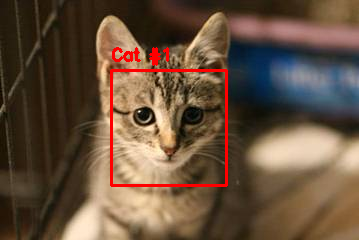

In [12]:
# import the necessary packages
import argparse
import cv2
from google.colab.patches import cv2_imshow

# load the input image and convert it to grayscale
image = cv2.imread('animals/cats/cats_00198.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# load the cat detector Haar cascade, then detect cat faces
# in the input image
detector = cv2.CascadeClassifier("haarcascade_frontalcatface.xml")
rects = detector.detectMultiScale(gray, scaleFactor=1.3,
	minNeighbors=5, minSize=(75, 75))

# loop over the cat faces and draw a rectangle surrounding each
for (i, (x, y, w, h)) in enumerate(rects):
  print('Cat face detected...')
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
  cv2.putText(image, "Cat #{}".format(i + 1), (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)

# show the detected cat faces
cv2_imshow(image)

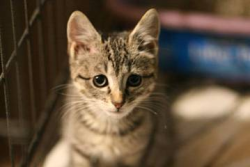

In [13]:
import imutils

# load the input image and convert it to grayscale
image = cv2.imread('animals/cats/cats_00198.jpg')

# What is we shrink it a bit?
image2 = imutils.resize(image, width=250)
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# load the cat detector Haar cascade, then detect cat faces
# in the input image
detector = cv2.CascadeClassifier("haarcascade_frontalcatface.xml")
rects = detector.detectMultiScale(gray, scaleFactor=1.3,
  minNeighbors=5, minSize=(75, 75))

# loop over the cat faces and draw a rectangle surrounding each
for (i, (x, y, w, h)) in enumerate(rects):
  print('Cat face detected...')
  cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 0, 255), 2)
  cv2.putText(image2, "Cat #{}".format(i + 1), (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)

# show the detected cat faces
cv2_imshow(image2)

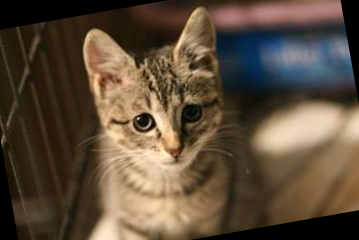

In [14]:
import imutils

# load the input image and convert it to grayscale
image = cv2.imread('animals/cats/cats_00198.jpg')

# What is we rotate it a bit?
image2 = imutils.rotate(image, 10)
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# load the cat detector Haar cascade, then detect cat faces
# in the input image
detector = cv2.CascadeClassifier("haarcascade_frontalcatface.xml")
rects = detector.detectMultiScale(gray, scaleFactor=1.3,
  minNeighbors=5, minSize=(75, 75))

# loop over the cat faces and draw a rectangle surrounding each
for (i, (x, y, w, h)) in enumerate(rects):
  print('Cat face detected...')
  cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 0, 255), 2)
  cv2.putText(image2, "Cat #{}".format(i + 1), (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)

# show the detected cat faces
cv2_imshow(image2)

## PyTorch

First, go into Runtime | Change Runtime Type and make sure you have enabled T4 GPU.

We will be training our classifier to recognize (1) cats (class 0) and (2) pandas (class 1).  Our data comes from Kaggle:

https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

In [15]:
!ls animals

cats  panda  test  training


### Imports, Config

In [16]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

import pandas as pd
import numpy as np

In [41]:
args={
    'batch_size': 64,
    'test_batch_size': 64,
    'epochs': 5,    # Training epochs
    'lr': 0.01,      # Learning rate, sometimes called eta
    'seed': 42,      # Random number seed
    'log_interval': 20, # How often to print log messages
    'save_file_name': 'learned-vgg16.pt', # Where to save the output
    'cuda': True     # Use GPU
}
n_classes = 2
kwargs={}

In [32]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Create the dataset
training_dataset = datasets.ImageFolder("animals/training", transform=transform)

test_dataset = datasets.ImageFolder("animals/test", transform=transform)

# Load MNIST in the data directory
train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


In [33]:
net = models.vgg16(pretrained=True)
net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freeze early layers

We freeze all of the existing layers in the network by setting `requires_grad` to `False`.

In [34]:
# Freeze early layers
for param in net.parameters():
    param.requires_grad = False

In [35]:
n_inputs = net.classifier[6].in_features

# Add on classifier
net.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

net.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [36]:
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


Let's try to move this to a GPU.

In [37]:
if args['cuda']:
  net = net.to('cuda')

In [38]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

### Main Training Routine

In [39]:
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,
          max_epochs_stop=3,n_epochs=20,print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if args['cuda']:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if args['cuda']:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

### Training the net

In [43]:
model, history = train(
    net,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    save_file_name=args['save_file_name'],
    max_epochs_stop=5,
    n_epochs=args['epochs'],
    print_every=1)

Model has been trained for: 5 epochs.


Epoch: 0 	Training Loss: 0.0145 	Validation Loss: 0.0133
		Training Accuracy: 99.56%	 Validation Accuracy: 99.50%

Epoch: 1 	Training Loss: 0.0049 	Validation Loss: 0.0150
		Training Accuracy: 99.78%	 Validation Accuracy: 99.50%

Epoch: 2 	Training Loss: 0.0051 	Validation Loss: 0.0121
		Training Accuracy: 99.78%	 Validation Accuracy: 99.50%

Epoch: 3 	Training Loss: 0.0131 	Validation Loss: 0.0260
		Training Accuracy: 99.56%	 Validation Accuracy: 99.50%

Epoch: 4 	Training Loss: 0.0205 	Validation Loss: 0.0152
		Training Accuracy: 99.28%	 Validation Accuracy: 99.50%

Best epoch: 2 with loss: 0.01 and acc: 99.50%
99.23 total seconds elapsed. 24.81 seconds per epoch.


# Does it recognize a panda from Wikipedia?

In [48]:
!wget https://www.zoo-berlin.de/fileadmin/_processed_/2/a/csm_Grosser_Panda_Meng_Meng_8457_8bb4a65066.jpg

--2024-11-11 18:47:06--  https://www.zoo-berlin.de/fileadmin/_processed_/2/a/csm_Grosser_Panda_Meng_Meng_8457_8bb4a65066.jpg
Resolving www.zoo-berlin.de (www.zoo-berlin.de)... 5.57.42.105
Connecting to www.zoo-berlin.de (www.zoo-berlin.de)|5.57.42.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262812 (257K) [image/jpeg]
Saving to: ‘csm_Grosser_Panda_Meng_Meng_8457_8bb4a65066.jpg’

csm_Grosser_Panda_M 100%[===================>] 256.65K  --.-KB/s    in 0.08s   

2024-11-11 18:47:07 (3.12 MB/s) - ‘csm_Grosser_Panda_Meng_Meng_8457_8bb4a65066.jpg’ saved [262812/262812]



In [60]:
from PIL import Image

# Set the model to evaluation mode
model.eval()

def classify_image(model, image_path):
# Define image transformations (same as used for ImageNet training)
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  # Load your image and apply the transformations
  image = Image.open(image_path)
  image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

  # Move the image tensor to the same device as the model (e.g., GPU)
  if torch.cuda.is_available():
      image_tensor = image_tensor.cuda()
      model = model.cuda()

  # Make a prediction
  with torch.no_grad():
      output = model(image_tensor)

  # Get the predicted class index with the highest probability
  _, predicted = torch.max(output.data, 1)

  return predicted.item()

classes = ['cat', 'panda']

In [61]:
# Print the predicted class index
print('Predicted class:', classes[classify_image(model, 'csm_Grosser_Panda_Meng_Meng_8457_8bb4a65066.jpg')])

Predicted class: panda


In [58]:
!wget https://www.usatoday.com/gcdn/authoring/authoring-images/2024/05/06/NPOH/73582010007-wildkingdom.png

--2024-11-11 18:52:54--  https://www.usatoday.com/gcdn/authoring/authoring-images/2024/05/06/NPOH/73582010007-wildkingdom.png
Resolving www.usatoday.com (www.usatoday.com)... 151.101.2.62, 151.101.66.62, 151.101.130.62, ...
Connecting to www.usatoday.com (www.usatoday.com)|151.101.2.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903893 (883K) [image/png]
Saving to: ‘73582010007-wildkingdom.png.1’

73582010007-wildkin 100%[===================>] 882.71K  --.-KB/s    in 0.08s   

2024-11-11 18:52:55 (11.4 MB/s) - ‘73582010007-wildkingdom.png.1’ saved [903893/903893]



In [62]:
print('Predicted class:', classes[classify_image(model, '73582010007-wildkingdom.png')])

Predicted class: cat
